In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [2]:
!nvidia-smi

Mon Apr 18 07:45:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#DATASET

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset

 88% 156M/178M [00:00<00:00, 204MB/s]
100% 178M/178M [00:00<00:00, 199MB/s]


In [6]:
!unzip *.zip && rm -rf *.zip

Archive:  online-payments-fraud-detection-dataset.zip
  inflating: PS_20174392719_1491204439457_log.csv  


#EXPLORATION

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
%matplotlib inline

In [2]:
data = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [12]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [13]:
data.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

Text(0, 0.5, 'Card Type')

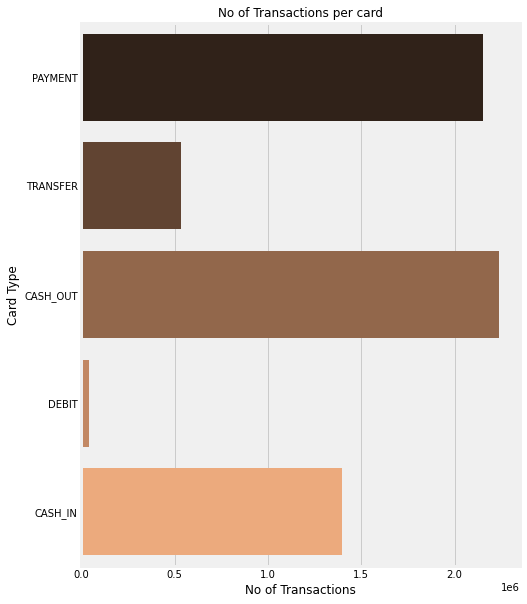

In [16]:
plt.figure(figsize=(7, 10))
sns.countplot(y="type", data=data, palette="copper")
plt.title("No of Transactions per card", fontsize=12)
plt.xlabel("No of Transactions")
plt.ylabel("Card Type")

In [21]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

import plotly.express as px
figure = px.pie(data, 
             values=quantity, 
             names=transactions,hole = 0.5, 
             title="Distribution of Transaction Type")
figure.show()

In [22]:
correlation = data.corr()

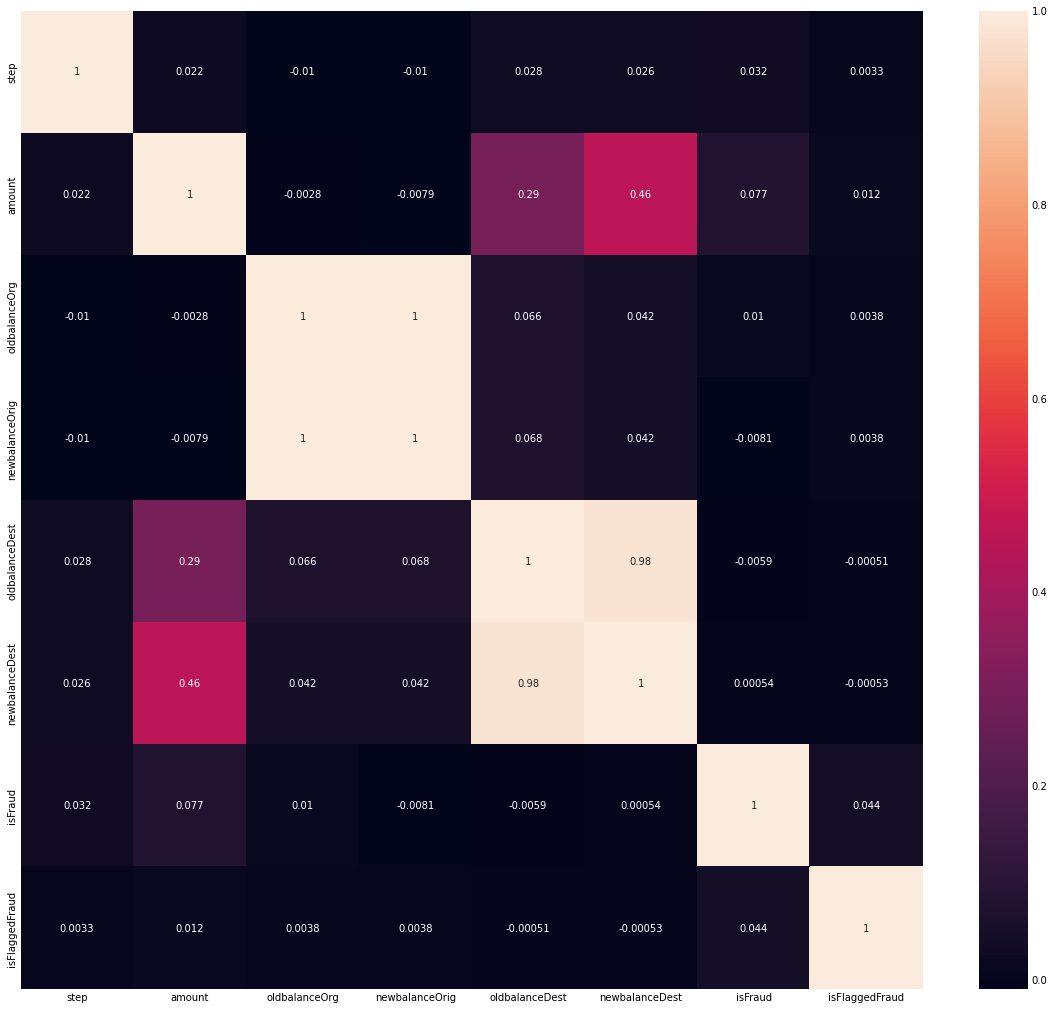

In [23]:
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

# FEATURE ENGINEERING

In [2]:
data = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")
data.head()

#transform the categorical into numeric
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
data.head()

# 0 = No Fraud and 1 = Fraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from collections import Counter

x = data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]].values
y = data["isFraud"].values

x, y = shuffle(x, y)
counter_before = Counter(y)
print(counter_before)

Counter({0: 6354407, 1: 8213})


In [4]:
#applying SMOTE for imbalance
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_data, y_data = oversample.fit_resample(x, y)

In [5]:
from collections import Counter
counter_after = Counter(y_data)
print(counter_after)

Counter({0: 6354407, 1: 6354407})


In [6]:
labels = to_categorical(y_data)

labels = np.array(labels)
x_data = np.array(x_data)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, labels, random_state=42, test_size=0.15)

In [8]:
X_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
X_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [9]:
print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)

X Train shape:  (10802491, 4, 1)
X Test shape:  (1906323, 4, 1)


#MODEL

In [10]:
import tensorflow as tf

In [17]:
# Conv Layers

inp = tf.keras.layers.Input(shape=(X_train.shape[1],1))
u1 = tf.keras.layers.Conv1D(filters=32, kernel_size=(3), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001))(inp)
u2 = tf.keras.layers.MaxPooling1D(pool_size=(2))(u1)
u3 = tf.keras.layers.Dropout(rate=0.2)(u2)
u4 = tf.keras.layers.Conv1D(filters=64, kernel_size=(3), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001))(u3)
u5 = tf.keras.layers.MaxPooling1D(pool_size=(2))(u4)
u6 = tf.keras.layers.Dropout(rate=0.2)(u5)
u7 = tf.keras.layers.Conv1D(filters=64, kernel_size=(3), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.001))(u6)
l = tf.keras.layers.Dropout(rate=0.2)(u7)

f = tf.keras.layers.Flatten()(l)
l1 = tf.keras.layers.Dense(units=512)(f)
l2 = tf.keras.layers.LeakyReLU(alpha=0.001)(l1)
l3 = tf.keras.layers.BatchNormalization()(l2)
l4 = tf.keras.layers.Dense(units=256)(l3)
l5 = tf.keras.layers.LeakyReLU(alpha=0.001)(l4)
l6 = tf.keras.layers.BatchNormalization()(l5)
l7 = tf.keras.layers.Dense(units=128)(l6)
l8 = tf.keras.layers.LeakyReLU(alpha=0.001)(l7)
l9 = tf.keras.layers.BatchNormalization()(l8)
l10 = tf.keras.layers.Dense(units=y_train.shape[-1])(l9)
outputs = tf.keras.layers.Activation("softmax")(l10)

model = tf.keras.models.Model(inputs = [inp], outputs = [outputs])

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 32)             128       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 2, 32)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                       

In [19]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
BATCH = 10000
EPOCHS = 5

In [21]:
history = model.fit(
  x_train, y_train,
  validation_data=(x_test ,y_test),
  epochs=EPOCHS,
  batch_size=BATCH
  # callbacks=callbacks
)

Epoch 1/5
1081/1081 [==============================] - 113s 102ms/step - loss: 0.0839 - accuracy: 0.9713 - val_loss: 0.1309 - val_accuracy: 0.9802
Epoch 2/5
1081/1081 [==============================] - 110s 102ms/step - loss: 0.0609 - accuracy: 0.9816 - val_loss: 0.1621 - val_accuracy: 0.9422
Epoch 3/5
1081/1081 [==============================] - 110s 102ms/step - loss: 0.0437 - accuracy: 0.9878 - val_loss: 0.2106 - val_accuracy: 0.8778
Epoch 4/5
1081/1081 [==============================] - 110s 101ms/step - loss: 0.0321 - accuracy: 0.9922 - val_loss: 1.9814 - val_accuracy: 0.5937
Epoch 5/5
1081/1081 [==============================] - 110s 102ms/step - loss: 0.0157 - accuracy: 0.9969 - val_loss: 0.0388 - val_accuracy: 0.9970


In [22]:
features = np.array([[4, 5000.60, 3000.60, 0.0]])
print(model.predict(features))

[[0.7918949  0.20810504]]


Text(0, 0.5, 'Accuracy')

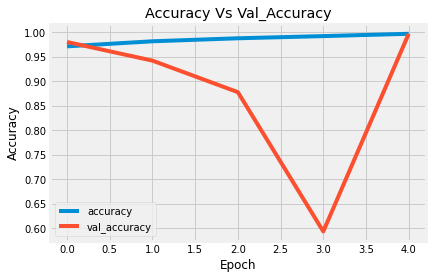

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

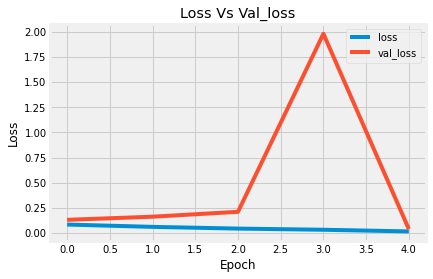

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.title('Loss Vs Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

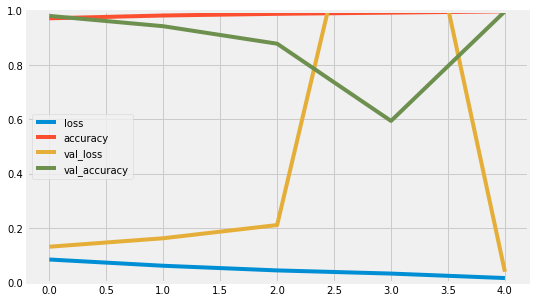

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#BY MUHAMMAD HANAN ASGHAR